In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

In [2]:
# Load all the training data

client = pd.read_csv(r'C:\Users\Inigo\OneDrive - University of Bristol\Coding Stuff\Applied ML\AppliedML2024\FinalProject\predict-energy-behavior-of-prosumers\client.csv')
forecast = pd.read_csv(r'C:\Users\Inigo\OneDrive - University of Bristol\Coding Stuff\Applied ML\AppliedML2024\FinalProject\predict-energy-behavior-of-prosumers\forecast_weather.csv')
electricity = pd.read_csv(r'C:\Users\Inigo\OneDrive - University of Bristol\Coding Stuff\Applied ML\AppliedML2024\FinalProject\predict-energy-behavior-of-prosumers\electricity_prices.csv')
gas = pd.read_csv(r'C:\Users\Inigo\OneDrive - University of Bristol\Coding Stuff\Applied ML\AppliedML2024\FinalProject\predict-energy-behavior-of-prosumers\gas_prices.csv')
historical = pd.read_csv(r'C:\Users\Inigo\OneDrive - University of Bristol\Coding Stuff\Applied ML\AppliedML2024\FinalProject\predict-energy-behavior-of-prosumers\historical_weather.csv')
train = pd.read_csv(r'C:\Users\Inigo\OneDrive - University of Bristol\Coding Stuff\Applied ML\AppliedML2024\FinalProject\predict-energy-behavior-of-prosumers\train.csv')

## Gas data

Combining the high and low price into one using averages/weighted average to reduce noise

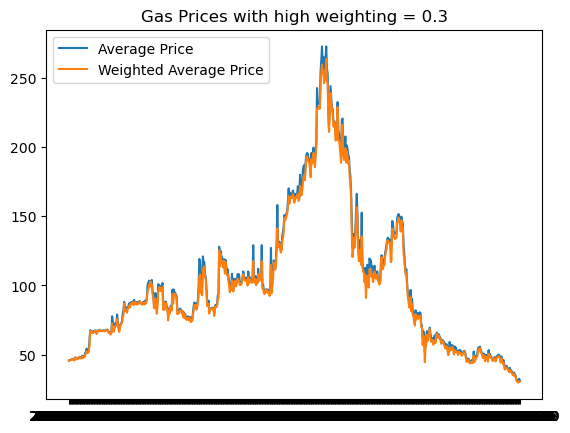

In [66]:
# plt.plot(gas_data["forecast_date"], gas_data["highest_price_per_mwh"])
# plt.plot(gas_data["forecast_date"], gas_data["lowest_price_per_mwh"])

gas["average_price_per_mwh"] = (gas["highest_price_per_mwh"] + gas["lowest_price_per_mwh"]) / 2
plt.plot(gas["forecast_date"], gas["average_price_per_mwh"], label="Average Price")

high_weight = 0.3

gas["weighted_average_price_per_mwh"] = gas["highest_price_per_mwh"] * high_weight + gas["lowest_price_per_mwh"] * (1 - high_weight)

plt.plot(gas["forecast_date"], gas["weighted_average_price_per_mwh"], label="Weighted Average Price")
# plt.plot(gas["forecast_date"], gas["highest_price_per_mwh"], label="high  Price")
# plt.plot(gas["forecast_date"], gas["lowest_price_per_mwh"], label="low Price")

plt.title(f"Gas Prices with high weighting = {high_weight}")
plt.legend()


# Looking at the train data

In [4]:
# Check what the train dataset looks like

print(train.dtypes)

nan_count = train['target'].isna().sum()
print(f"Number of NaN values: {nan_count}")

# Check for infinities
inf_count =train['target'].replace([np.inf, -np.inf], np.nan).isna().sum() - nan_count
print(f"Number of infinity values: {inf_count}") 

county                  int64
is_business             int64
product_type            int64
target                float64
is_consumption          int64
datetime               object
data_block_id           int64
row_id                  int64
prediction_unit_id      int64
dtype: object
Number of NaN values: 528
Number of infinity values: 0


In [5]:
# Remove the rows which contain Nan values in the target column

train = train.dropna(subset=['target'])


# Looking at the client info

Correltion between the 2 variables: 0.7543533925558777


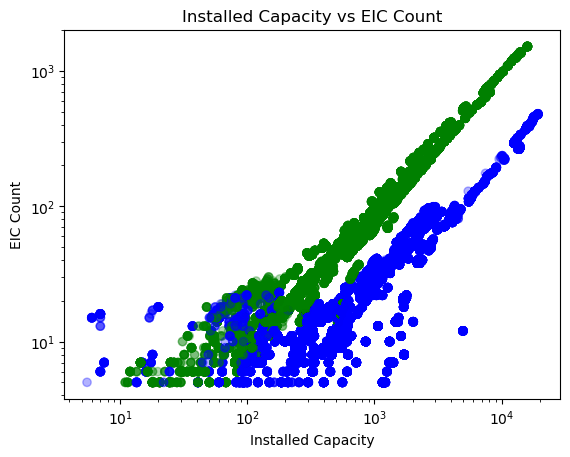

In [6]:
# Checking correltion between EIC and installed capacity

print(f"Correltion between the 2 variables: {client['installed_capacity'].corr(client['eic_count'])}")

client["installed_capacity"].corr(client["eic_count"])
colors = client['is_business'].map({1: 'blue', 0: 'green'})

plt.scatter(client["installed_capacity"], client["eic_count"], c=colors, alpha=0.3)
plt.xlabel("Installed Capacity")
plt.ylabel("EIC Count")
plt.title("Installed Capacity vs EIC Count")
plt.xscale("log")
plt.yscale("log")

In [7]:
# How does client info match up with train data?

data_block_count = (train["data_block_id"] == 2) & (train["datetime"] == "2021-09-01 00:00:00")
print(data_block_count.sum())
print(data_block_count)

data_block_count = (client["data_block_id"] == 2).sum()
print(data_block_count)

0
0          False
1          False
2          False
3          False
4          False
           ...  
2018347    False
2018348    False
2018349    False
2018350    False
2018351    False
Length: 2017824, dtype: bool
61


In [8]:
# Convert 'datetime' column to datetime if it's not already
train['datetime'] = pd.to_datetime(train['datetime'])

# Now apply the filter and count
data_block_count = ((train["data_block_id"] == 2) & (train["datetime"] == "2021-09-01 00:00:00")).sum()

# Print the count
print(f"Number of rows where 'data_block_id' is 2 and 'datetime' is '2021-09-01 00:00:00': {data_block_count}")

Number of rows where 'data_block_id' is 2 and 'datetime' is '2021-09-01 00:00:00': 0


# Getting all the data into same data set

In [9]:
print(f"Electricty start: {electricity['forecast_date'].min()} End: {electricity['forecast_date'].max()}")
print(f"Forecast start: {forecast['forecast_datetime'].min()} End: {forecast['forecast_datetime'].max()}")
print(f"Gas start: {gas['forecast_date'].min()} End: {gas['forecast_date'].max()}")
print(f"Historical start: {historical['datetime'].min()} End: {historical['datetime'].max()}")
print(f"Train start: {train['datetime'].min()} End: {train['datetime'].max()}")
print(f"Client start: {client['date'].min()} End: {client['date'].max()}")

Electricty start: 2021-09-01 00:00:00 End: 2023-05-30 23:00:00
Forecast start: 2021-09-01 03:00:00 End: 2023-06-01 02:00:00
Gas start: 2021-09-01 End: 2023-05-30
Historical start: 2021-09-01 00:00:00 End: 2023-05-30 10:00:00
Train start: 2021-09-01 00:00:00 End: 2023-05-31 23:00:00
Client start: 2021-09-01 End: 2023-05-29


In [47]:
# Match the county to the data

county_mapping = pd.read_csv(r"C:\Users\Inigo\OneDrive - University of Bristol\Coding Stuff\Applied ML\AppliedML2024\FinalProject\predict-energy-behavior-of-prosumers\weather_station_to_county_mapping.csv")

# Remove empty rows and create a dictionary

county_mapping = county_mapping[county_mapping.notnull().all(axis=1)].sort_values(by="county")

result_dict = dict(zip(zip(round(county_mapping['latitude'],1), round(county_mapping['longitude'],1)), county_mapping['county']))

# Use dicitionary to map the county to the weather data

forecast_copy = forecast.copy()

forecast_copy['county'] = [result_dict.get((x, y), -1) for x, y in zip(forecast['latitude'], forecast['longitude'])]
                           
historical_copy = historical.copy()

historical_copy['county'] = [result_dict.get((x, y), -1) for x, y in zip(historical['latitude'], historical['longitude'])]

print(forecast_copy['county'].value_counts())

county
-1.0     1926288
 0.0      183456
 15.0     152880
 7.0      152880
 10.0     122304
 11.0     122304
 5.0      122304
 2.0      122304
 14.0      91728
 4.0       91728
 9.0       91728
 3.0       91728
 6.0       61152
 13.0      30576
 8.0       30576
 1.0       30576
Name: count, dtype: int64


From this we can see most rows dont have a county

In [38]:
print(historical_copy['county'].value_counts())

county
-1.0     962327
 0.0      91650
 15.0     76375
 7.0      76375
 10.0     61100
 11.0     61100
 5.0      61100
 2.0      61100
 14.0     45825
 4.0      45825
 9.0      45825
 3.0      45825
 6.0      30550
 13.0     15275
 8.0      15275
 1.0      15275
Name: count, dtype: int64


In [48]:
# Remove all points with no county

forecast_copy = forecast_copy[forecast_copy['county'] != -1]
historical_copy = historical_copy[historical_copy['county'] != -1]

In [49]:
# Remove irrelevant columns

forecast_copy = forecast_copy.drop(columns=['latitude', 'longitude','origin_datetime','hours_ahead','data_block_id'])
historical_copy = historical_copy.drop(columns=['latitude', 'longitude','data_block_id'])

In [57]:
# Average the weather for each county

forecast_avg = forecast_copy.groupby(['forecast_datetime', 'county']).mean().reset_index()
historical_avg = historical_copy.groupby(['datetime', 'county']).mean().reset_index()

# Now there are 15 data points for each hour, 1 for each county

# Convert datetime to datetime object

forecast_avg['forecast_datetime'] = pd.to_datetime(forecast_avg['forecast_datetime'])
historical_avg['datetime'] = pd.to_datetime(historical_avg['datetime'])

# Labelling the columns with forecast and historical

forecast_avg = forecast_avg.add_suffix('_fore')
historical_avg = historical_avg.add_suffix('_hist')

In [60]:
# Now add the weather data to the train data and make sure the dates match up 

merged_train = pd.merge(train, forecast_avg, how='left', left_on=['datetime', 'county'], right_on=['forecast_datetime_fore', 'county_fore'])

merged_train_2 = pd.merge(merged_train, historical_avg, how='left', left_on=['datetime', 'county'], right_on=['datetime_hist', 'county_hist'])

In [70]:
# Now do the gas prices
# Times each day by 24 hours to match up with the train

gas_copy = gas.copy()

df = gas_copy

df['forecast_date'] = pd.to_datetime(df['forecast_date'])
df.set_index('forecast_date', inplace=True)

# Resample the DataFrame to hourly and forward fill the values
hourly_df = df.resample('H').ffill()

C:\Users\Inigo\AppData\Local\Temp\ipykernel_3956\1043801265.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_df = df.resample('H').ffill()


In [68]:
empty = pd.DataFrame()

for i,j in gas:
    print(j)
    

ValueError: too many values to unpack (expected 2)